# Natural Language Processing for IT Service Ticket Classification

#### *Roberto Requejo Fernandez*

## 0.0 Library Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from collections import Counter
import re
import contractions
from tqdm import tqdm

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words_en = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

nlp = spacy.load('en_core_web_lg')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rrobe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rrobe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rrobe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1.0 Loading and Initial Analysis

In [2]:
df = pd.read_csv('all_tickets_processed_improved_v3.csv')
df.rename({'Document': 'ticket_text'},axis=1,inplace=True)
print(f"Dataset size: {len(df) }")
df.head()

Dataset size: 47837


,ticket_text,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


#### Reduction of Dataset Dimensions

The dataset was reduced from 47,837 instances to 5,000, and the number of classes was decreased from 8 to 2. The class reduction strategy involved creating two balanced categories: 2,500 instances belonging to the hardware class and 2,500 instances consisting of elements from the remaining classes. This configuration was designed to streamline the analysis and facilitate binary classification (hardware vs. non-hardware) with a perfectly balanced dataset.

In [3]:
df_clase_especifica = df[df['Topic_group'] == 'Hardware'].sample(n=2500, random_state=42)
df_otras_clases = df[df['Topic_group'] != 'Hardware'].sample(n=2500, random_state=42)
sub_df = pd.concat([df_clase_especifica, df_otras_clases], ignore_index=True)
sub_df = sub_df.sample(frac=1, random_state=42).reset_index(drop=True)
sub_df['Topic_group'] = np.where(sub_df['Topic_group'] == 'Hardware', 1, 0)

print(f"Total de filas: {len(sub_df)}")
print(f"\nDistribución de clases:")
print(sub_df['Topic_group'].value_counts())
sub_df.rename({'Topic_group': 'is_hardware'},axis=1,inplace=True)
df = sub_df.copy()


Total de filas: 5000

Distribución de clases:
Topic_group
1    2500
0    2500
Name: count, dtype: int64


#### Text Preprocessing Function

This function performs comprehensive text preprocessing for natural language processing tasks. It executes the following sequential operations:

1. **Lowercasing**: Converts all characters to lowercase to ensure uniformity and case-insensitive processing.

2. **Contraction Expansion**: Expands contracted words (e.g., "don't" becomes "do not") using the contractions library to standardize text format.

3. **Character Filtering**: Removes all characters except alphanumeric characters (a-z, 0-9) and whitespace using regular expressions, eliminating special characters and punctuation.

4. **Tokenization**: Splits the text into individual tokens (words) using the `word_tokenize` function.

5. **Stop Word Removal**: Filters out common English stop words (e.g., "the", "is", "and") that typically don't contribute significant meaning to the analysis.

6. **Lemmatization**: Reduces each word to its base or dictionary form (lemma), converting variations like "running", "ran", "runs" to "run".

7. **Reconstruction**: Joins the processed tokens back into a single string with spaces between words.

**Return Value**: A cleaned, normalized text string ready for further NLP analysis or model input.

In [4]:
def text_preprocess(text):
  text = text.lower()
  text = contractions.fix(text)
  text = re.sub(r'[^a-z0-9]\s', '', text)
  text = word_tokenize(text)
  text = [token for token in text if token not in stop_words_en]
  text = [lemmatizer.lemmatize(word) for word in text]
  text = ' '.join(text)
  return text

In [5]:
df['ticket_text_clean'] = df['ticket_text'].progress_apply(text_preprocess)
df.head()

100%|██████████| 5000/5000 [00:05<00:00, 841.39it/s] 


,ticket_text,is_hardware,ticket_text_clean
0,set up and install latest apple and prepare fo...,1,set install latest apple prepare purchase hi p...
1,purchase request for it final owner team id ha...,0,purchase request final owner team id approved ...
2,new project code oracle wednesday july pm code...,0,new project code oracle wednesday july pm code...
3,temporary laptop for en hello please allocatio...,1,temporary laptop en hello please allocation wo...
4,issues sent thursday re notification multiple ...,1,issue sent thursday notification multiple unav...


#### Initial Analysis

DISTRIBUCIÓN DE CLASES
is_hardware
1    2500
0    2500
Name: count, dtype: int64

Total de clases: 2


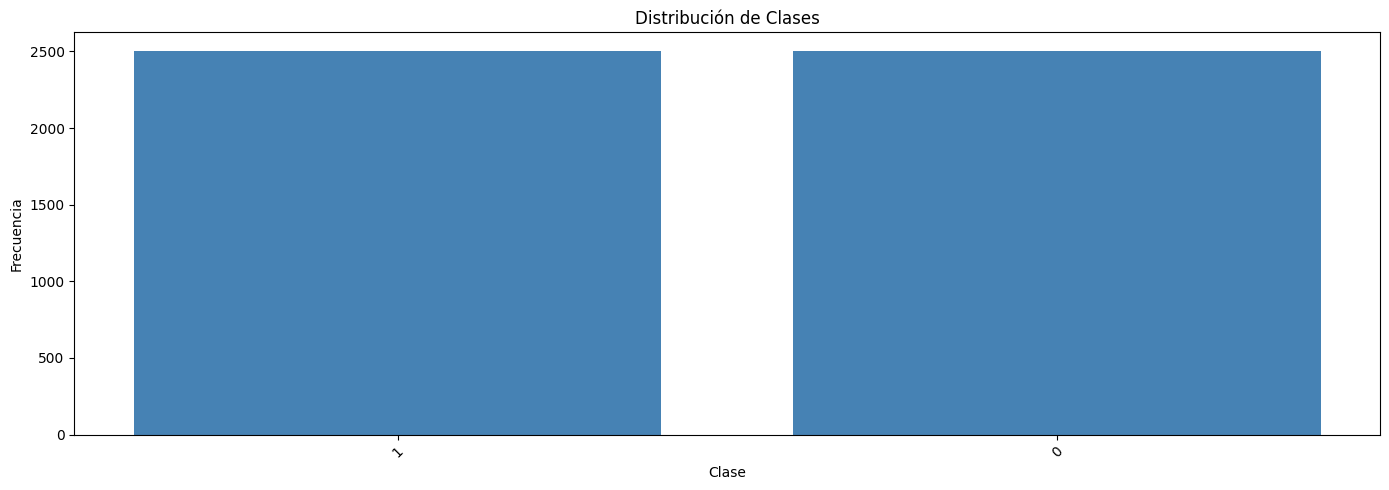

In [6]:
print("DISTRIBUCIÓN DE CLASES")
print("="*50)
class_counts = df['is_hardware'].value_counts()
print(class_counts)
print(f"\nTotal de clases: {df['is_hardware'].nunique()}")

fig, axes = plt.subplots(figsize=(14, 5))

# Gráfico de barras
axes.bar(class_counts.index.astype(str), class_counts.values, color='steelblue')
axes.set_xlabel('Clase')
axes.set_ylabel('Frecuencia')
axes.set_title('Distribución de Clases')
axes.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 1.1 Vector Creation

This code creates two different numerical representations of the cleaned ticket text:

1. **Word2Vec Vectorization**: Converts each ticket text into dense semantic vectors using a pre-trained NLP model, capturing the contextual meaning of words.

2. **TF-IDF Vectorization**: Transforms the ticket text into statistical vectors based on term frequency and importance across the dataset.

Both vectorization methods are stored in separate columns for comparison and subsequent model training.

In [7]:
def getWord2VecVector(word):
  return nlp(word).vector

df['ticket_text_vector_word2vec'] = df['ticket_text_clean'].progress_apply(getWord2VecVector)
tfidf_vectorizer = TfidfVectorizer()
vectorized_vectors = tfidf_vectorizer.fit_transform(df['ticket_text_clean'])
df['ticket_text_vector_tfidf'] = list(vectorized_vectors.toarray())
df.head()

100%|██████████| 5000/5000 [01:18<00:00, 63.44it/s]


,ticket_text,is_hardware,ticket_text_clean,ticket_text_vector_word2vec,ticket_text_vector_tfidf
0,set up and install latest apple and prepare fo...,1,set install latest apple prepare purchase hi p...,"[-0.17018993, 0.17141141, -0.12400036, -0.0875...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,purchase request for it final owner team id ha...,0,purchase request final owner team id approved ...,"[0.05700964, 0.12114485, -0.1915924, -0.017506...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,new project code oracle wednesday july pm code...,0,new project code oracle wednesday july pm code...,"[-0.006437827, 0.12603916, -0.074105866, 0.044...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,temporary laptop for en hello please allocatio...,1,temporary laptop en hello please allocation wo...,"[-0.12902002, 0.10233685, -0.115679376, 0.1103...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,issues sent thursday re notification multiple ...,1,issue sent thursday notification multiple unav...,"[-0.022183187, 0.13566215, -0.13891359, -0.014...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### t-SNE Dimensionality Reduction

This code applies t-SNE (t-Distributed Stochastic Neighbor Embedding), a visualization technique that reduces high-dimensional vectors to 2D while preserving local relationships between data points. Both Word2Vec (300 dimensions) and TF-IDF vectors are transformed into 2D coordinates and stored in the dataframe, enabling visual analysis of how tickets cluster based on their text content and revealing patterns that would be impossible to observe in the original high-dimensional space.

In [8]:
X_word2vec = df['ticket_text_vector_word2vec'].to_list()
X_word2vec = np.concatenate(X_word2vec, axis=0).reshape(-1, 300)
model_word2vec = TSNE(n_components=2, perplexity=5)
resultado_word2vec = model_word2vec.fit_transform(X_word2vec)

df['tsne_1_word2vec'] = resultado_word2vec[:,0]
df['tsne_2_word2vec'] = resultado_word2vec[:,1]

model_tfidf = TSNE(n_components=2, perplexity=5)
X_tfidf = np.array(df['ticket_text_vector_tfidf'].to_list())
resultado_tfidf = model_tfidf.fit_transform(X_tfidf)
df['tsne_1_tfidf'] = resultado_tfidf[:,0]
df['tsne_2_tfidf'] = resultado_tfidf[:,1]


df.head()

,ticket_text,is_hardware,ticket_text_clean,ticket_text_vector_word2vec,ticket_text_vector_tfidf,tsne_1_word2vec,tsne_2_word2vec,tsne_1_tfidf,tsne_2_tfidf
0,set up and install latest apple and prepare fo...,1,set install latest apple prepare purchase hi p...,"[-0.17018993, 0.17141141, -0.12400036, -0.0875...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.081543,-44.456062,85.108505,-11.056355
1,purchase request for it final owner team id ha...,0,purchase request final owner team id approved ...,"[0.05700964, 0.12114485, -0.1915924, -0.017506...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",80.349602,-33.553604,96.542419,21.430489
2,new project code oracle wednesday july pm code...,0,new project code oracle wednesday july pm code...,"[-0.006437827, 0.12603916, -0.074105866, 0.044...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",24.062782,61.516785,-24.684752,13.667138
3,temporary laptop for en hello please allocatio...,1,temporary laptop en hello please allocation wo...,"[-0.12902002, 0.10233685, -0.115679376, 0.1103...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",26.833090,-30.535070,52.968754,12.072088
4,issues sent thursday re notification multiple ...,1,issue sent thursday notification multiple unav...,"[-0.022183187, 0.13566215, -0.13891359, -0.014...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-41.781986,-25.929113,30.486271,-55.070587


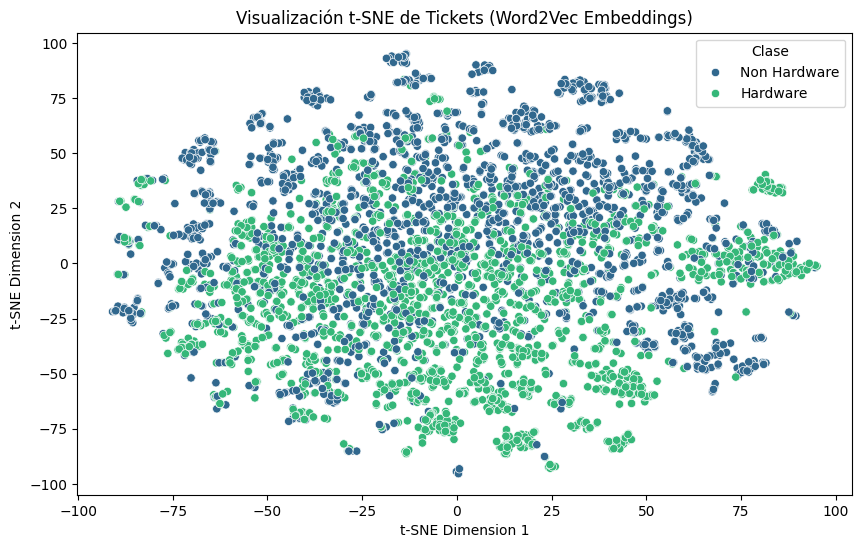

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1_word2vec', y='tsne_2_word2vec', hue='is_hardware', data=df, palette='viridis')
plt.title('Visualización t-SNE de Tickets (Word2Vec Embeddings)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Get current legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create custom labels
custom_labels = ['Non Hardware' if label == '0' else 'Hardware' for label in labels]

# Update legend with custom labels
plt.legend(handles, custom_labels, title='Clase')
plt.show()

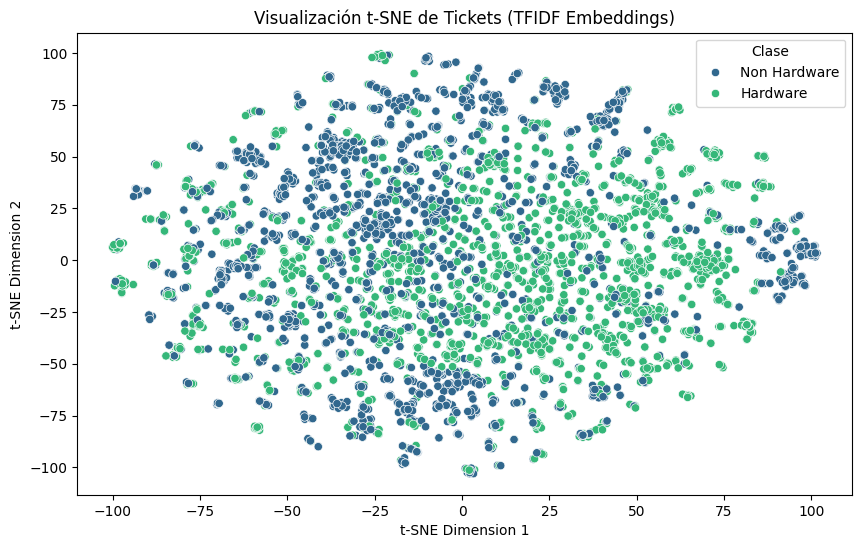

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1_tfidf', y='tsne_2_tfidf', hue='is_hardware', data=df, palette='viridis')
plt.title('Visualización t-SNE de Tickets (TFIDF Embeddings)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Get current legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create custom labels
custom_labels = ['Non Hardware' if label == '0' else 'Hardware' for label in labels]

# Update legend with custom labels
plt.legend(handles, custom_labels, title='Clase')
plt.show()

## 2.0 Classification Models

### 2.0.1 Functions and Utility

#### Confusion Matrix Visualization Function

This function creates a visual confusion matrix heatmap comparing true labels versus predicted labels, and calculates key classification metrics including accuracy, precision, recall, F1 score, and specificity. It provides both a graphical representation of model performance and detailed numerical metrics for evaluating classification results.

In [11]:
def plot_confusion_matrix(y_true, y_pred, labels=['Not Hardware', 'Hardware'], 
                         title='Confusion Matrix', cmap='Blues'):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'}, linewidths=1, linecolor='gray')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print additional metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    specificity = tn / (tn + fp)
    
    print("\nConfusion Matrix Breakdown:")
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")

In [12]:
def prepare_train_test_data(df, text_column='ticket_text_vector_tfidf', target_column='is_hardware', test_size=0.2, random_state=42):
    X = np.array(df[text_column].tolist())
    y = df[target_column].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

#### Model Performance Tracking

This code creates an empty dataframe to store and compare performance metrics (Accuracy, Precision, Recall, and F1-Score) across different models and datasets throughout the analysis.

In [13]:
results_df = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

### 2.1 Logistic Regression

Logistic Regression is a classification algorithm that predicts the probability of a binary outcome (two possible categories like spam/not spam, pass/fail, diseased/healthy).
How it works:
*   Takes input features (like age, income, test scores)
*   Combines them using weights (learned from data)
*   Passes the result through a sigmoid function - an S-shaped curve that outputs a probability between 0 and 1
*   If probability ≥ 0.5 → predict class 1; if < 0.5 → predict class 0

Example:
Predicting if a student passes an exam based on study hours. The model might output 0.75 (75% probability of passing), so it predicts "pass."

Key characteristics:
*   Despite "regression" in the name, it's used for classification
*   Simple, fast, and interpretable
*   Assumes a linear relationship between features and log-odds of the outcome
*   Often used as a baseline model before trying more complex algorithms

The model learns the best weights during training to maximize prediction accuracy.

---

We split the data into training (80%) and testing (20%) sets to evaluate how well our model performs on new data.

- **Features**: TF-IDF vectors from ticket text
- **Target**: Whether the ticket is hardware-related (`is_hardware`)

In [14]:
X_train, X_test, y_train, y_test = prepare_train_test_data(df, text_column='ticket_text_vector_tfidf', target_column='is_hardware')

#### Training the Model

In [15]:
lr_model = LogisticRegression(random_state=42, max_iter=1000, C=1.0)
lr_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
y_pred = lr_model.predict(X_test)
y_train_pred = lr_model.predict(X_train)

#### Saving Results

We store the model's performance metrics to compare against future models.

In [17]:
# Create new rows as DataFrames
train_results = pd.DataFrame([{
    'Model': 'Logistic Regression',
    'Dataset': 'Train',
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'Precision': precision_score(y_train, y_train_pred),
    'Recall': recall_score(y_train, y_train_pred),
    'F1-Score': f1_score(y_train, y_train_pred),
}])

test_results = pd.DataFrame([{
    'Model': 'Logistic Regression',
    'Dataset': 'Test',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
}])

results_df = pd.concat([results_df, train_results, test_results], ignore_index=True)

#### Confusion Matrixs

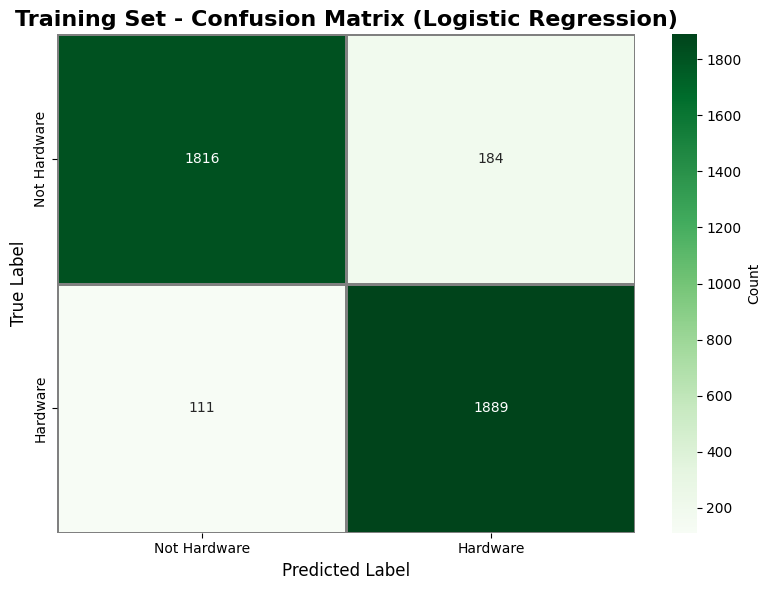


Confusion Matrix Breakdown:

Accuracy: 0.9263
Precision: 0.9112
Recall: 0.9445
F1 Score: 0.9276
Specificity: 0.9080


In [18]:
plot_confusion_matrix(y_train, y_train_pred, labels=['Not Hardware', 'Hardware'], title='Training Set - Confusion Matrix (Logistic Regression)',cmap='Greens')

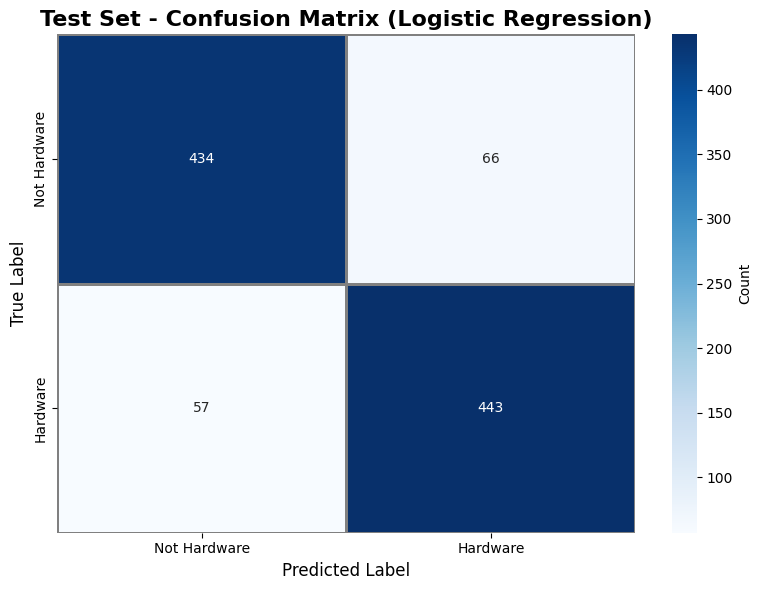


Confusion Matrix Breakdown:

Accuracy: 0.8770
Precision: 0.8703
Recall: 0.8860
F1 Score: 0.8781
Specificity: 0.8680


In [19]:
plot_confusion_matrix(y_test, y_pred, labels=['Not Hardware', 'Hardware'], title='Test Set - Confusion Matrix (Logistic Regression)', cmap='Blues')

### 2.2 Random Forest Clasifier

Random Forest is an ensemble learning algorithm that creates multiple decision trees and combines their predictions to make more accurate and stable classifications.

How it works:
*   Creates many decision trees (a "forest") during training
*   Each tree is built on a random subset of the data (bootstrapping)
*   Each split in a tree considers only a random subset of features
*   For prediction, each tree "votes" on the class
*   Final prediction is the majority vote across all trees

Example:
Predicting if an email is spam. Tree 1 might focus on word frequency, Tree 2 on sender reputation, Tree 3 on link count. If 80 out of 100 trees vote "spam," the forest predicts spam.

Key characteristics:
*   Handles both classification and regression tasks
*   Robust to overfitting due to averaging multiple trees
*   Works well with high-dimensional data and mixed feature types
*   Provides feature importance rankings
*   Can handle missing values and doesn't require feature scaling
*   Less interpretable than single decision trees but more accurate

---

We split the data into training (80%) and testing (20%) sets to evaluate how well our model performs on new data.

- **Features**: TF-IDF vectors from ticket text
- **Target**: Whether the ticket is hardware-related (`is_hardware`)

In [20]:
X_train, X_test, y_train, y_test = prepare_train_test_data(df, text_column='ticket_text_vector_tfidf', target_column='is_hardware')

#### Training the Model

In [21]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

#### Saving Results

We store the model's performance metrics to compare against future models.

In [23]:
# Create new rows as DataFrames
train_results = pd.DataFrame([{
    'Model': 'Random Forest',
    'Dataset': 'Train',
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'Precision': precision_score(y_train, y_train_pred),
    'Recall': recall_score(y_train, y_train_pred),
    'F1-Score': f1_score(y_train, y_train_pred),
}])

test_results = pd.DataFrame([{
    'Model': 'Random Forest',
    'Dataset': 'Test',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
}])

results_df = pd.concat([results_df, train_results, test_results], ignore_index=True)

In [24]:
results_df.head()

,Model,Dataset,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,Train,0.92625,0.911240,0.9445,0.927572
1,Logistic Regression,Test,0.87700,0.870334,0.8860,0.878097
2,Random Forest,Train,1.00000,1.000000,1.0000,1.000000
3,Random Forest,Test,0.85400,0.864198,0.8400,0.851927


#### Confusion Matrixs

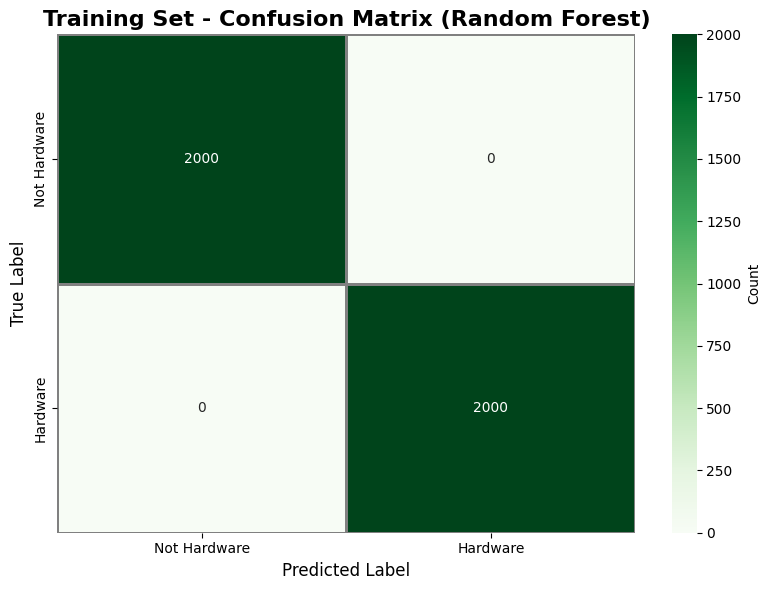


Confusion Matrix Breakdown:

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Specificity: 1.0000


In [25]:
plot_confusion_matrix(y_train, y_train_pred, labels=['Not Hardware', 'Hardware'], title='Training Set - Confusion Matrix (Random Forest)', cmap='Greens')

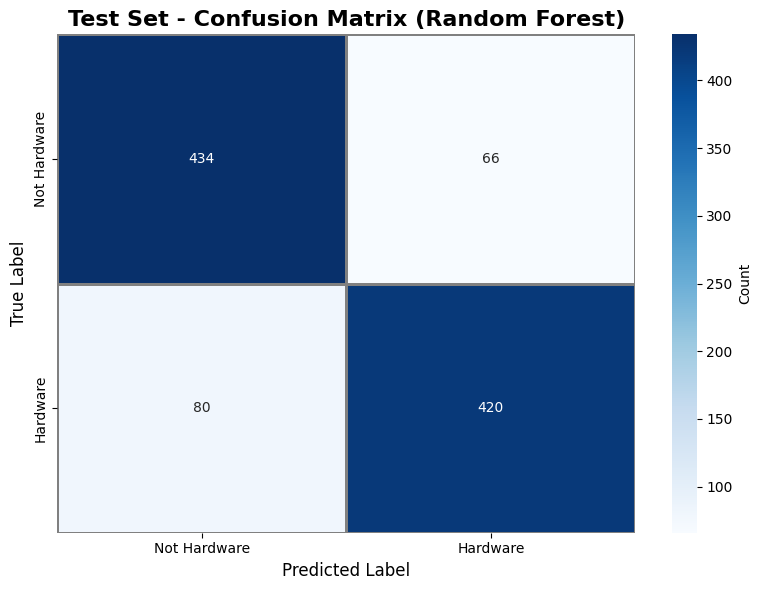


Confusion Matrix Breakdown:

Accuracy: 0.8540
Precision: 0.8642
Recall: 0.8400
F1 Score: 0.8519
Specificity: 0.8680


In [26]:
plot_confusion_matrix(y_test, y_pred, labels=['Not Hardware', 'Hardware'],title='Test Set - Confusion Matrix (Random Forest)', cmap='Blues')

### 2.3 Support Vector Machine (SVM)

Support Vector Machine is a powerful classification algorithm that finds the optimal boundary (hyperplane) to separate different classes by maximizing the margin between them.

How it works:
*   Plots data points in n-dimensional space (where n = number of features)
*   Finds the hyperplane that best separates the classes
*   Maximizes the distance (margin) between the hyperplane and the nearest data points from each class
*   These nearest points are called "support vectors" - they define the decision boundary
*   Uses the kernel trick to handle non-linear relationships by transforming data into higher dimensions

Example:
Classifying tumors as benign or malignant based on size and texture. SVM draws a line (in 2D) or plane (in higher dimensions) that separates benign cases from malignant ones with the widest possible gap, using only the critical border cases (support vectors) to define this boundary.

Key characteristics:
*   Effective in high-dimensional spaces
*   Memory efficient (only uses support vectors, not all training data)
*   Works well with clear margins of separation
*   Versatile through different kernel functions (linear, polynomial, RBF/Gaussian, sigmoid)
*   Can handle both linear and non-linear classification
*   Less effective on very large datasets due to training time
*   Sensitive to feature scaling - normalization is important

The model learns to position the hyperplane where it's furthest from the closest points of both classes, creating the most robust separation possible.

---

We split the data into training (80%) and testing (20%) sets to evaluate how well our model performs on new data.

- **Features**: TF-IDF vectors from ticket text
- **Target**: Whether the ticket is hardware-related (`is_hardware`)

In [27]:
X_train, X_test, y_train, y_test = prepare_train_test_data(df, text_column='ticket_text_vector_tfidf', target_column='is_hardware')

#### Training the Model

In [28]:
svm_model = SVC(random_state=42, kernel='rbf', C=1.0, probability=True)
svm_model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [29]:
y_pred = svm_model.predict(X_test)
y_train_pred = svm_model.predict(X_train)

#### Saving Results

We store the model's performance metrics to compare against future models.

In [30]:
# Create new rows as DataFrames
train_results = pd.DataFrame([{
    'Model': 'SVM',
    'Dataset': 'Train',
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'Precision': precision_score(y_train, y_train_pred),
    'Recall': recall_score(y_train, y_train_pred),
    'F1-Score': f1_score(y_train, y_train_pred),
}])

test_results = pd.DataFrame([{
    'Model': 'SVM',
    'Dataset': 'Test',
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
}])

results_df = pd.concat([results_df, train_results, test_results], ignore_index=True)

#### Confusion Matrixs

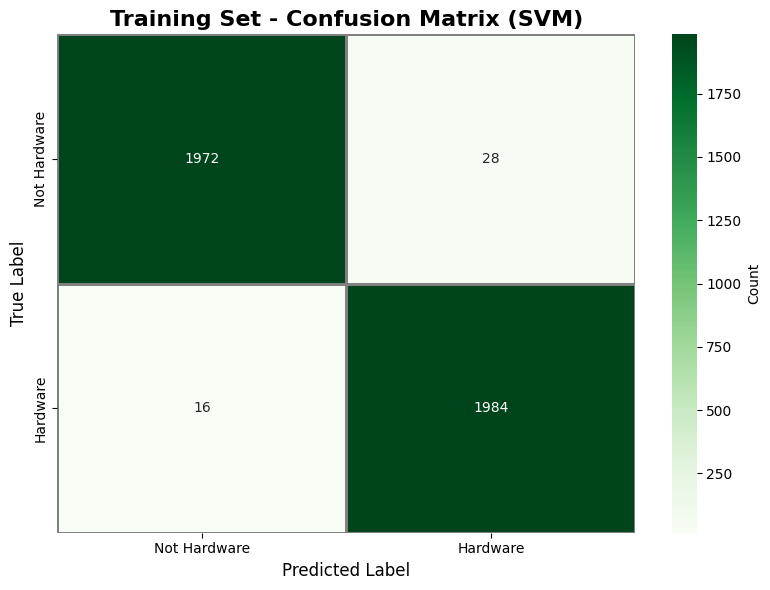


Confusion Matrix Breakdown:

Accuracy: 0.9890
Precision: 0.9861
Recall: 0.9920
F1 Score: 0.9890
Specificity: 0.9860


In [31]:
plot_confusion_matrix(y_train, y_train_pred, labels=['Not Hardware', 'Hardware'], title='Training Set - Confusion Matrix (SVM)', cmap='Greens')

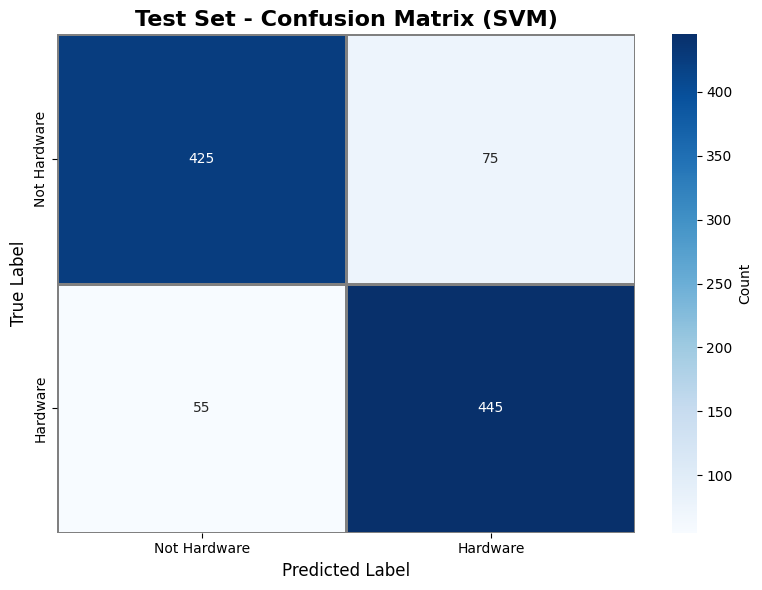


Confusion Matrix Breakdown:

Accuracy: 0.8700
Precision: 0.8558
Recall: 0.8900
F1 Score: 0.8725
Specificity: 0.8500


In [32]:
plot_confusion_matrix(y_test, y_pred, 
                     labels=['Not Hardware', 'Hardware'],
                     title='Test Set - Confusion Matrix (SVM)',
                     cmap='Blues')

## 3.0 Deep Learning Models

### 3.1 LSTM Network

LSTM is a specialized type of Recurrent Neural Network (RNN) designed to learn patterns in sequential data while remembering important information over long periods and forgetting irrelevant details.

How it works:
*   Processes data sequentially (one step at a time, like reading words in a sentence)
*   Contains special memory cells with three "gates" that control information flow:
    *   Forget Gate: Decides what information to discard from memory
    *   Input Gate: Decides what new information to store in memory
    *   Output Gate: Decides what information to output based on current input and memory
*   Maintains a cell state (long-term memory) that carries information across many time steps
*   Each gate uses sigmoid functions (0-1 range) to determine how much information passes through

Example:
Predicting the next word in a sentence: "The cat sat on the ___". The LSTM remembers "cat" from earlier in the sequence and uses this context to predict "mat" or "floor" rather than unrelated words. It can maintain this context even in much longer sequences where simple RNNs would forget.

Key characteristics:
*   Excels at sequence prediction tasks (time series, text, speech, video)
*   Solves the "vanishing gradient problem" that plagued traditional RNNs
*   Can capture both short-term and long-term dependencies in data
*   Bidirectional LSTMs can process sequences in both forward and backward directions
*   More complex and computationally expensive than simple RNNs
*   Requires significant training data and careful tuning

---

We split the data into training (80%) and testing (20%) sets to evaluate how well our model performs on new data.

- **Features**: TF-IDF vectors from ticket text
- **Target**: Whether the ticket is hardware-related (`is_hardware`)

In [33]:
X = np.array(df['ticket_text_vector_word2vec'].tolist())
X = X.reshape(X.shape[0], 1, 300)

y = df['is_hardware'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [34]:
model_lstm = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], 300)),
    Dropout(0.3),
    
    Bidirectional(LSTM(64)),
    Dropout(0.3),
   
    Dense(64, activation='relu'),
    Dropout(0.2),  
    Dense(32, activation='relu'), 

    Dense(2, activation='softmax')
])

model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model_lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7131 - loss: 0.5613 - val_accuracy: 0.7400 - val_loss: 0.5067 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7987 - loss: 0.4413 - val_accuracy: 0.7575 - val_loss: 0.4859 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8138 - loss: 0.4089 - val_accuracy: 0.7987 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8100 - loss: 0.3999 - val_accuracy: 0.8100 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8316 - loss: 0.3750 - val_accuracy: 0.8062 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8384 - loss: 0.3545 - val_accuracy: 0.7987 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8431 - loss: 0

In [35]:
y_train_pred = model_lstm.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [36]:
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


#### Saving Results

We store the model's performance metrics to compare against future models.

In [37]:
# Create new rows as DataFrames
train_results = pd.DataFrame([{
    'Model': 'LSTM',
    'Dataset': 'Train',
    'Accuracy': accuracy_score(y_train_true_classes, y_train_pred_classes),
    'Precision': precision_score(y_train_true_classes, y_train_pred_classes),
    'Recall': recall_score(y_train_true_classes, y_train_pred_classes),
    'F1-Score': f1_score(y_train_true_classes, y_train_pred_classes),
}])

test_results = pd.DataFrame([{
    'Model': 'LSTM',
    'Dataset': 'Test',
    'Accuracy': accuracy_score(y_test_classes, y_pred_classes),
    'Precision': precision_score(y_test_classes, y_pred_classes),
    'Recall': recall_score(y_test_classes, y_pred_classes),
    'F1-Score': f1_score(y_test_classes, y_pred_classes),
}])

results_df = pd.concat([results_df, train_results, test_results], ignore_index=True)

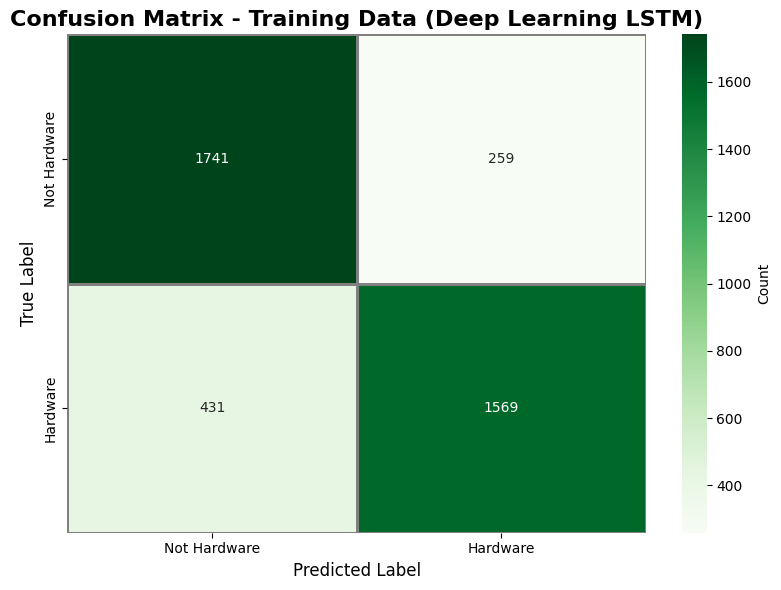


Confusion Matrix Breakdown:

Accuracy: 0.8275
Precision: 0.8583
Recall: 0.7845
F1 Score: 0.8197
Specificity: 0.8705


In [38]:
plot_confusion_matrix(y_train_true_classes, y_train_pred_classes,
                     title='Confusion Matrix - Training Data (Deep Learning LSTM)',
                     cmap='Greens')

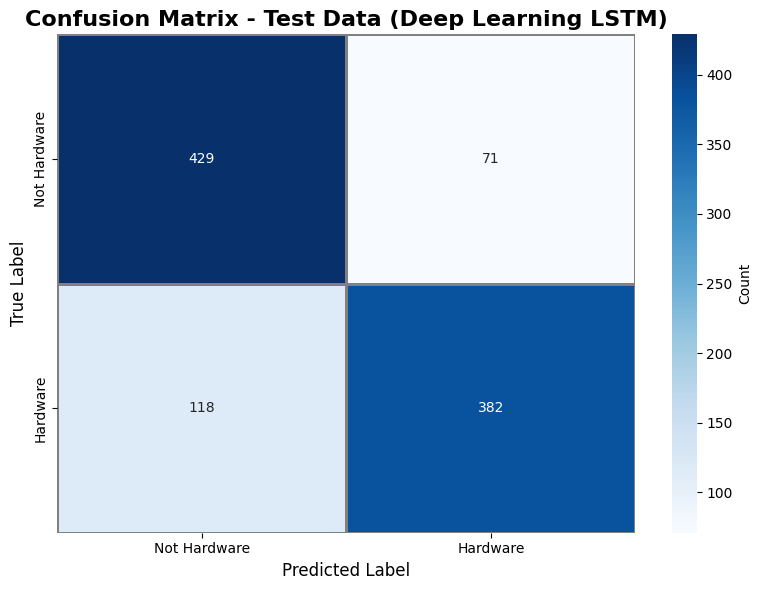


Confusion Matrix Breakdown:

Accuracy: 0.8110
Precision: 0.8433
Recall: 0.7640
F1 Score: 0.8017
Specificity: 0.8580


In [39]:
plot_confusion_matrix(y_test_classes, y_pred_classes,
                     title='Confusion Matrix - Test Data (Deep Learning LSTM)',
                     cmap='Blues')

### 3.2 CNN Model

Convolutional Neural Network is a deep learning algorithm specifically designed to process grid-like data (images, video) by automatically detecting and learning spatial patterns and features through layered filters.

How it works:
*   Convolutional Layers: Apply filters/kernels that slide across the input to detect features (edges, textures, shapes)
*   Activation Function (ReLU): Adds non-linearity, allowing the network to learn complex patterns
*   Pooling Layers: Reduce spatial dimensions while keeping important information (downsampling)
*   Fully Connected Layers: At the end, flatten the features and make final classification decisions
*   Each layer learns increasingly complex features: early layers detect edges, middle layers detect shapes, deep layers detect complete objects

Example:
Classifying a photo as "cat" or "dog." The first convolutional layer might detect edges and curves. The second layer combines these into patterns like fur texture or ear shapes. Deeper layers recognize complete features like faces or body parts. Finally, the fully connected layer combines all features to output "cat" with 95% confidence.

Key characteristics:
*   Spatial hierarchy: Automatically learns feature hierarchies from simple to complex
*   Parameter sharing: Same filter applied across entire image, reducing parameters dramatically
*   Translation invariance: Can detect features regardless of their position in the image
*   Extremely effective for image and video tasks
*   Requires less preprocessing than traditional computer vision methods
*   Can be very deep (100+ layers in modern architectures)
*   Computationally intensive but highly parallelizable (GPU-friendly)

The network learns optimal filters during training, automatically discovering what features are most important for the task rather than requiring manual feature engineering.

---

We split the data into training (80%) and testing (20%) sets to evaluate how well our model performs on new data.

- **Features**: TF-IDF vectors from ticket text
- **Target**: Whether the ticket is hardware-related (`is_hardware`)

In [40]:
X = np.array(df['ticket_text_vector_word2vec'].tolist())
X = X.reshape(X.shape[0], 1, 300)

y = df['is_hardware'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [41]:
model_cnn = Sequential([
    # First Convolutional Block
    Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 300)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Second Convolutional Block
    Conv1D(filters=256, kernel_size=1, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Third Convolutional Block
    Conv1D(filters=128, kernel_size=1, activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    
    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    
    # Output layer
    Dense(2, activation='softmax')
])

# Compile model
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train model
history = model_cnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6744 - loss: 0.6675 - val_accuracy: 0.7312 - val_loss: 0.6455 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7625 - loss: 0.4996 - val_accuracy: 0.7400 - val_loss: 0.5761 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7853 - loss: 0.4547 - val_accuracy: 0.7450 - val_loss: 0.5172 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8056 - loss: 0.4261 - val_accuracy: 0.7950 - val_loss: 0.4606 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8197 - loss: 0.3999 - val_accuracy: 0.8062 - val_loss: 0.4079 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8328 - loss: 0.3795 - val_accuracy: 0.8213 - val_loss: 0.3814 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8425 - loss: 0

In [42]:
y_train_pred = model_cnn.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [43]:
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


#### Saving Results

We store the model's performance metrics to compare against future models.

In [44]:
# Create new rows as DataFrames
train_results = pd.DataFrame([{
    'Model': 'CNN',
    'Dataset': 'Train',
    'Accuracy': accuracy_score(y_train_true_classes, y_train_pred_classes),
    'Precision': precision_score(y_train_true_classes, y_train_pred_classes),
    'Recall': recall_score(y_train_true_classes, y_train_pred_classes),
    'F1-Score': f1_score(y_train_true_classes, y_train_pred_classes),
}])

test_results = pd.DataFrame([{
    'Model': 'CNN',
    'Dataset': 'Test',
    'Accuracy': accuracy_score(y_test_classes, y_pred_classes),
    'Precision': precision_score(y_test_classes, y_pred_classes),
    'Recall': recall_score(y_test_classes, y_pred_classes),
    'F1-Score': f1_score(y_test_classes, y_pred_classes),
}])

results_df = pd.concat([results_df, train_results, test_results], ignore_index=True)

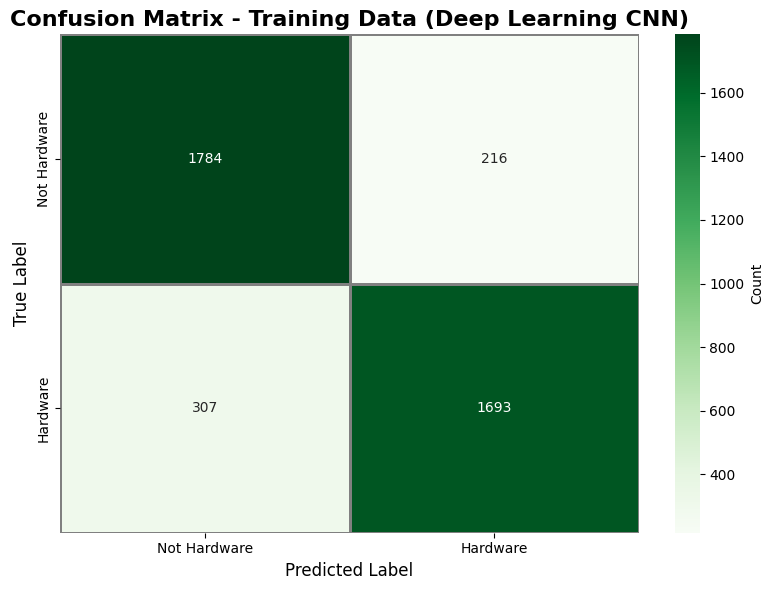


Confusion Matrix Breakdown:

Accuracy: 0.8692
Precision: 0.8869
Recall: 0.8465
F1 Score: 0.8662
Specificity: 0.8920


In [45]:
plot_confusion_matrix(y_train_true_classes, y_train_pred_classes,
                     title='Confusion Matrix - Training Data (Deep Learning CNN)',
                     cmap='Greens')

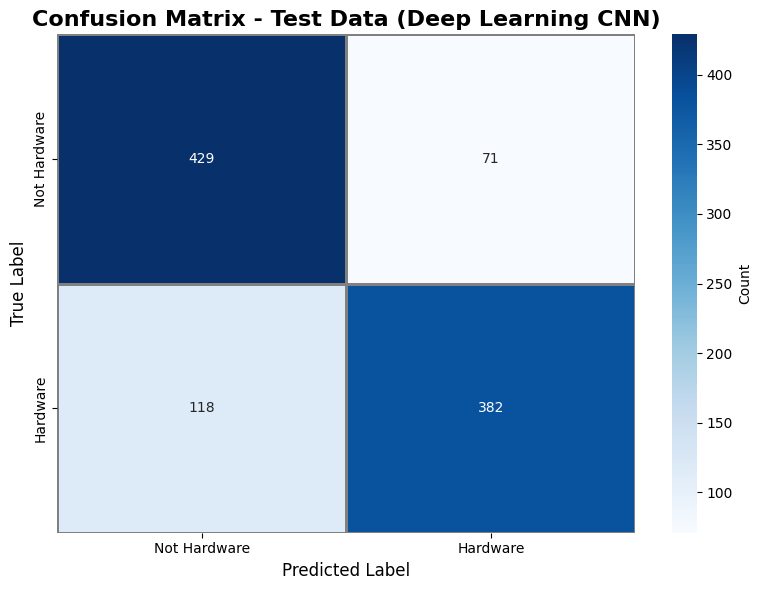


Confusion Matrix Breakdown:

Accuracy: 0.8110
Precision: 0.8433
Recall: 0.7640
F1 Score: 0.8017
Specificity: 0.8580


In [46]:
plot_confusion_matrix(y_test_classes, y_pred_classes,
                     title='Confusion Matrix - Test Data (Deep Learning CNN)',
                     cmap='Blues')

## 4.0 Results and Conclusions

In [47]:
train_data = results_df[results_df['Dataset'] == 'Train']
test_data = results_df[results_df['Dataset'] == 'Test']
models = train_data['Model'].unique()
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

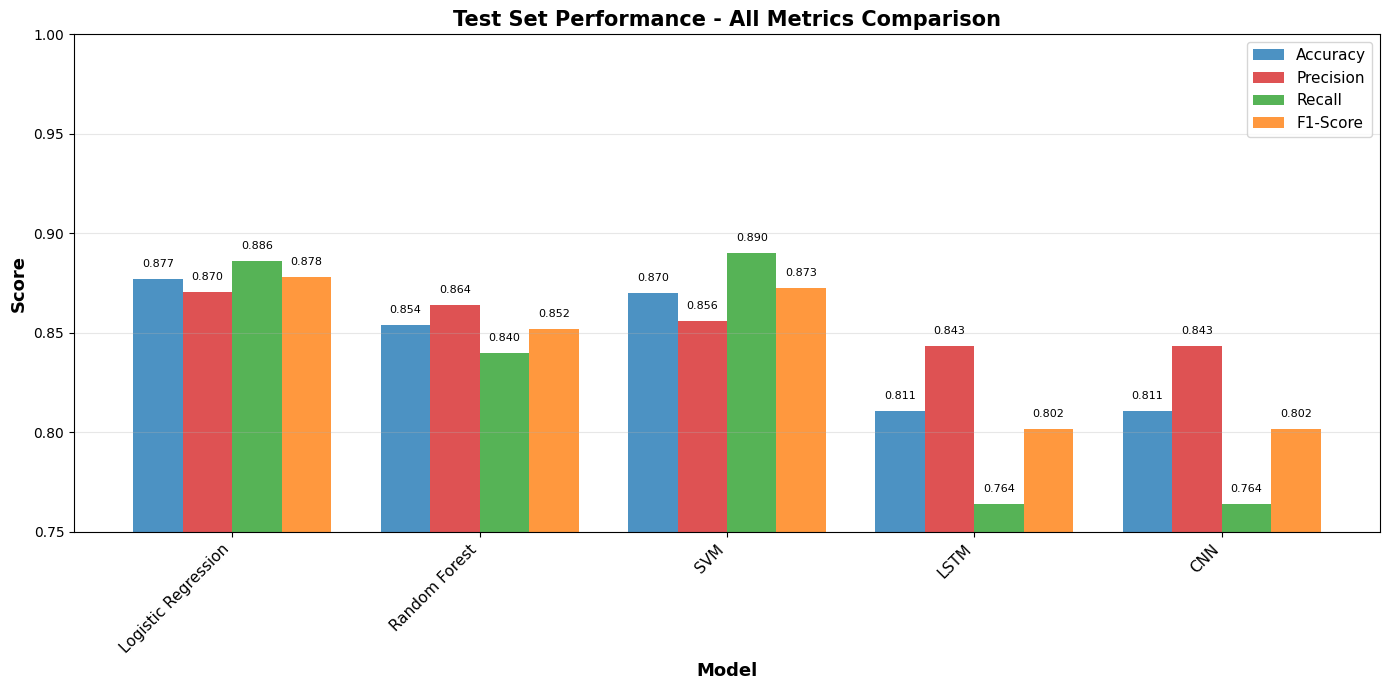

In [48]:
fig, ax = plt.subplots(figsize=(14, 7))
x_pos = np.arange(len(models))
bar_width = 0.2

colors_metrics = ['#1f77b4',  # azul fuerte
                  '#d62728',  # rojo intenso
                  '#2ca02c',  # verde vibrante
                  '#ff7f0e']  # naranja fuerte

for idx, metric in enumerate(metrics):
    offset = (idx - 1.5) * bar_width
    values = test_data[metric].values
    bars = ax.bar(x_pos + offset, values, bar_width, label=metric, 
                  alpha=0.8, color=colors_metrics[idx])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
               f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Model', fontweight='bold', fontsize=13)
ax.set_ylabel('Score', fontweight='bold', fontsize=13)
ax.set_title('Test Set Performance - All Metrics Comparison', fontweight='bold', fontsize=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=11, loc='upper right')
ax.set_ylim([0.75, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

GRAPH 2: OVERFITTING ANALYSIS


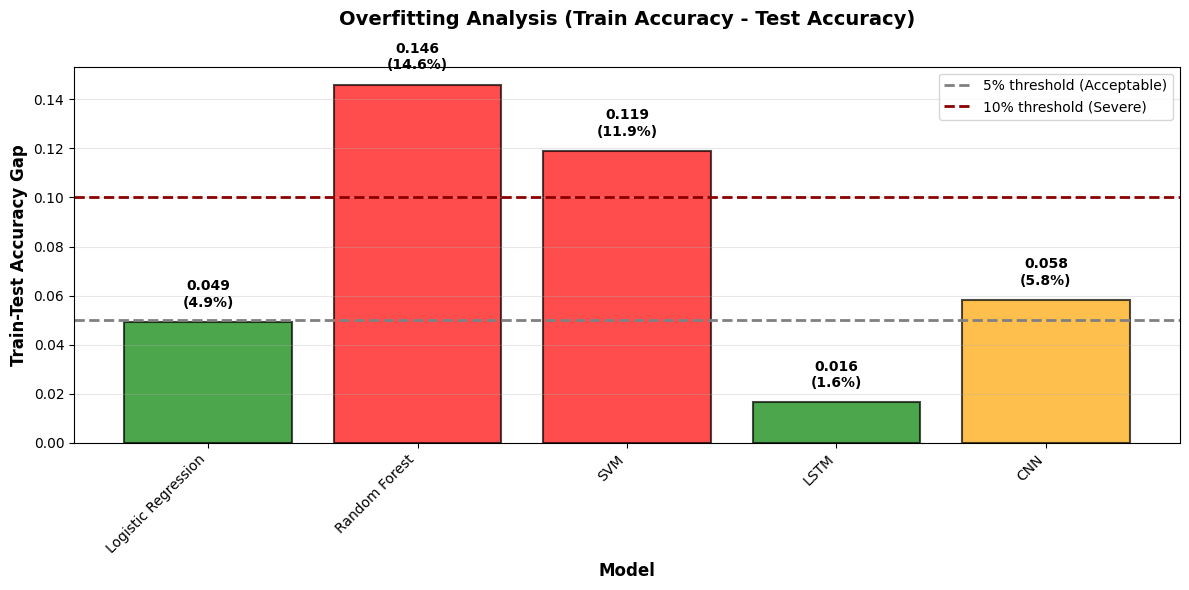

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

train_acc = train_data['Accuracy'].values
test_acc = test_data['Accuracy'].values
overfitting_gap = train_acc - test_acc

x_pos = np.arange(len(models))
colors = ['red' if gap > 0.1 else 'orange' if gap > 0.05 else 'green' for gap in overfitting_gap]

bars = ax.bar(x_pos, overfitting_gap, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Train-Test Accuracy Gap', fontweight='bold', fontsize=12)
ax.set_title('Overfitting Analysis (Train Accuracy - Test Accuracy)', fontweight='bold', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.axhline(y=0.05, color='gray', linestyle='--', linewidth=2, label='5% threshold (Acceptable)')
ax.axhline(y=0.1, color='darkred', linestyle='--', linewidth=2, label='10% threshold (Severe)')
ax.set_title(
    'Overfitting Analysis (Train Accuracy - Test Accuracy)',
    fontweight='bold',
    fontsize=14,
    pad=30  # increase padding here (default is 6)
)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, gap) in enumerate(zip(bars, overfitting_gap)):
    ax.text(bar.get_x() + bar.get_width()/2., gap + 0.005,
           f'{gap:.3f}\n({gap*100:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.1 Key Findings

1. Random Forest - Severe Overfitting Detected:

Training Accuracy: 100% (perfect memorization)
Test Accuracy: 85.4% (significant performance drop)
Gap: 14.6% (highest among all models)

Interpretation: The model achieved perfect training accuracy by creating overly complex decision rules that memorized the training data, including noise and outliers. This resulted in poor generalization to new data.
Implication: Despite appearing superior during training, this model is not suitable for deployment without significant regularization.

2. SVM - Significant Overfitting:

Training Accuracy: 98.9%
Test Accuracy: 87.0%
Gap: 11.9%

Interpretation: Also shows substantial overfitting, though less severe than Random Forest. The model is too complex for the given dataset.

3. Logistic Regression - Optimal Balance ✓ :

Training Accuracy: 92.6%
Test Accuracy: 87.7%
Gap: 4.9% (within acceptable range)
Test F1-Score: 0.8781 (highest)

Interpretation: This model demonstrates excellent generalization with minimal overfitting. The small gap indicates it learned genuine patterns rather than memorizing training data.
Recommendation: Best candidate for deployment due to superior test performance, minimal overfitting, and model interpretability.

4. Deep Learning Models (LSTM/CNN) - Underperforming:

Both models show the lowest test performance (~82% accuracy)
LSTM has minimal overfitting (1.4% gap) but low overall performance
CNN shows moderate overfitting (7.3% gap)

Interpretation: These models may be underperforming due to insufficient training data, suboptimal architecture, or inadequate hyperparameter tuning. Deep learning models typically require larger datasets to achieve their full potential.